# predict AAPL 5 minute rate of change, <br/> using 3 year dukascopy data

In [1]:
# imports
import common
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# inputs
PREDICTION_SIZE = 5
aapl_file_path = r'C:\Users\asaf\Desktop\DS_workshop-project\stock_market_neural_nets\data\relevant\dukascopy\BID\AAPL.csv'

## 1) get aaple data

In [3]:
df = pd.read_csv(aapl_file_path)

# rename columns
new_cols_map = {col: col.lower() for col in df}
new_cols_map['Local time'] = "datetime"
df.rename(columns=new_cols_map, inplace=True)

# convert datetime type (string to datetime)
df['datetime'] = df['datetime'].str.replace(r"\:00\.000 GMT\+0\d00","")
df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')

to keep things stupid simple, focus on specific columns

In [4]:
df = df[['datetime', 'close']]
df.head()

,datetime,close
0,2017-01-26 00:00:00,121.864
1,2017-01-26 00:01:00,121.864
2,2017-01-26 00:02:00,121.864
3,2017-01-26 00:03:00,121.864
4,2017-01-26 00:04:00,121.864


## 2) preprocessing

first look

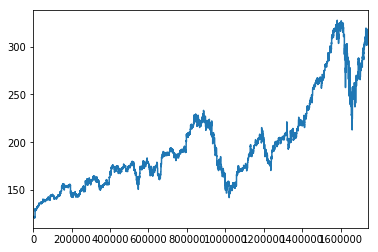

In [5]:
df['close'].plot()

In [6]:
df.describe()

,close
count,1.742520e+06
mean,1.961501e+02
std,4.746335e+01
min,1.206500e+02
25%,1.599700e+02
50%,1.849480e+02
75%,2.178373e+02
max,3.277580e+02


are there Nans?

In [7]:
df.isnull().sum()

datetime    0
close       0
dtype: int64

good :-)

### 2.1) dealing with data outside of trading sessions
delete data that is in-between trading sessions, that is not between 16:30-23:00

In [8]:
df = df.set_index(['datetime']).between_time("16:30", "23:00").reset_index()
df

,datetime,close
0,2017-01-26 16:30:00,121.710
1,2017-01-26 16:31:00,121.891
2,2017-01-26 16:32:00,122.060
3,2017-01-26 16:33:00,122.240
4,2017-01-26 16:34:00,122.213
...,...,...
473105,2020-05-19 22:56:00,313.657
473106,2020-05-19 22:57:00,313.547
473107,2020-05-19 22:58:00,313.438
473108,2020-05-19 22:59:00,312.998


### 2.2) add features

add time columns

In [9]:
common.add_times(df, 'datetime')

In [10]:
df.head().transpose()

,0,1,2,3,4
datetime,2017-01-26 16:30:00,2017-01-26 16:31:00,2017-01-26 16:32:00,2017-01-26 16:33:00,2017-01-26 16:34:00
close,121.71,121.891,122.06,122.24,122.213
minute,30,31,32,33,34
hour,16,16,16,16,16
day,26,26,26,26,26
month,1,1,1,1,1
minute_of_day,990,991,992,993,994
day_of_week,3,3,3,3,3


calc different rocs

In [11]:
roc_vals = [1,3,5]
for val in roc_vals:
    df['roc'+str(val)] = common.rate_of_change(df, 'close', val)

In [12]:
df.head(6).transpose()

,0,1,2,3,4,5
datetime,2017-01-26 16:30:00,2017-01-26 16:31:00,2017-01-26 16:32:00,2017-01-26 16:33:00,2017-01-26 16:34:00,2017-01-26 16:35:00
close,121.71,121.891,122.06,122.24,122.213,122.042
minute,30,31,32,33,34,35
hour,16,16,16,16,16,16
day,26,26,26,26,26,26
month,1,1,1,1,1,1
minute_of_day,990,991,992,993,994,995
day_of_week,3,3,3,3,3,3
roc1,NaN,0.00148714,0.00138648,0.00147468,-0.000220877,-0.0013992
roc3,NaN,NaN,NaN,0.00435461,0.0026417,-0.000147468


### 2.3) add target

In [13]:
df['target'] = common.rate_of_change(df, 'close', -PREDICTION_SIZE)

In [14]:
df.head(6).transpose()

,0,1,2,3,4,5
datetime,2017-01-26 16:30:00,2017-01-26 16:31:00,2017-01-26 16:32:00,2017-01-26 16:33:00,2017-01-26 16:34:00,2017-01-26 16:35:00
close,121.71,121.891,122.06,122.24,122.213,122.042
minute,30,31,32,33,34,35
hour,16,16,16,16,16,16
day,26,26,26,26,26,26
month,1,1,1,1,1,1
minute_of_day,990,991,992,993,994,995
day_of_week,3,3,3,3,3,3
roc1,NaN,0.00148714,0.00138648,0.00147468,-0.000220877,-0.0013992
roc3,NaN,NaN,NaN,0.00435461,0.0026417,-0.000147468


### 2.4) final cleaning

drop first 5 minutes of every day (so we wont use roc5 which been calculated on data from yesterday)

In [15]:
df = df[df['minute_of_day'] >= 995]

drop last 5 minutes in whole dataset (missing targets)

In [16]:
df = df.iloc[:-PREDICTION_SIZE]

In [17]:
df.tail().transpose()

,473100,473101,473102,473103,473104
datetime,2020-05-19 22:51:00,2020-05-19 22:52:00,2020-05-19 22:53:00,2020-05-19 22:54:00,2020-05-19 22:55:00
close,313.847,314.307,313.868,313.618,313.488
minute,51,52,53,54,55
hour,22,22,22,22,22
day,19,19,19,19,19
month,5,5,5,5,5
minute_of_day,1371,1372,1373,1374,1375
day_of_week,1,1,1,1,1
roc1,-0.00187637,0.00146568,-0.00139672,-0.000796513,-0.000414517
roc3,-0.00270418,-0.00130276,-0.00180958,-0.000729655,-0.00260573


drop datetime - as some models cant deal with this datatype

In [18]:
df.drop(columns=['datetime'], inplace=True)

## 3) modeling

how much data we have?

In [19]:
len(df)

467055

### 3.1) splitting data into training, validation, and test sets

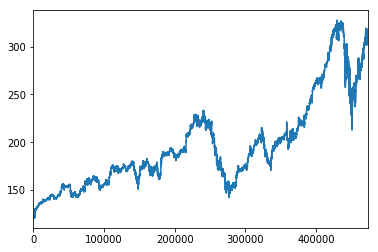

In [20]:
df['close'].plot()

In [21]:
# similar split point to IEX split point (on IEX-aapl notebook)
split_point = 412800

train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

percentange wise:

In [22]:
print(f"train_df = {len(train_df) / len(df):.2f}")
print(f"test_df = {len(test_df) / len(df):.2f}")

train_df = 0.88
test_df = 0.12


### 3.2) evaluation metric
continuing the stupid simple spirit - i use MSE

### 3.2) baseline
baseline model will be a model which predict the current roc5 to be the next 5 minutes roc5 (target) <br/>
it is probably a terrible model - with little to no predictive value. <br/>
need to think of a way to measure that.

In [23]:
mean_squared_error(train_df['target'], train_df['roc5'])

3.0246816919985784e-06

In [24]:
mean_squared_error(test_df['target'], test_df['roc5'])

1.4293582580193629e-05

### 3.3) random forest

at first, i use simple 10 trees forest

In [25]:
train_features = train_df.drop(columns=['target'])

In [26]:
m_forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=5, random_state=1)
%time m_forest.fit(train_features, train_df['target'])

Wall time: 4.32 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [27]:
mean_squared_error(train_df['target'], m_forest.predict(train_features))

1.8078276365340659e-06

In [28]:
mean_squared_error(test_df['target'],
                   m_forest.predict(test_df.drop(columns=['target'])))

1.0075446301688727e-05

good results? <br/>
at least not worst than the baseline <br/>
note - in both models, training error > validation error - wierd

### 3.4) MLP

In [30]:
m_mlp = MLPRegressor(hidden_layer_sizes=tuple([20 for _ in range(20)]), 
                     random_state=1,
                     activation='logistic')
%time m_mlp.fit(train_features, train_df['target'])

Wall time: 2min 57s


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
       power_t=0.5, random_state=1, shuffle=True, solver='adam',
       tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [31]:
mean_squared_error(train_df['target'], m_mlp.predict(train_features))

1.9969405473005558e-06

In [32]:
mean_squared_error(test_df['target'],
                   m_mlp.predict(test_df.drop(columns=['target'])))

9.545679134464024e-06

random forest > MLP in sample,<br/>
random forest < MLP out of sample.

thinking face

calculate PnL

In [38]:
print(f" PnL forest = {common.rate_of_change_PL(m_forest.predict(train_features), train_df['target']).mean()}")
print(f" PnL MLP    = {common.rate_of_change_PL(m_mlp.predict(train_features), train_df['target']).mean()}")

 PnL forest = 2.8364474705599846e-05
 PnL MLP    = -8.197533049076843e-06


In [41]:
print(f" PnL forest = {common.rate_of_change_PL(m_forest.predict(test_df.drop(columns=['target'])), test_df['target']).mean()}")
print(f" PnL MLP    = {common.rate_of_change_PL(m_mlp.predict(test_df.drop(columns=['target'])), test_df['target']).mean()}")

 PnL forest = -2.8167529099597222e-06
 PnL MLP    = -1.0205352859424781e-07


lossing money :(